In [44]:
import pandas as pd
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import scam_job_detector.ML_logic.preprocessor as pre
print("Imported from:", pre.__file__)
print("Functions available:", dir(pre))
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

Imported from: /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/ML_logic/preprocessor.py
Functions available: ['ColumnTransformer', 'FunctionTransformer', 'OneHotEncoder', 'OrdinalEncoder', 'Pipeline', 'SimpleImputer', 'TfidfVectorizer', '__builtins__', '__cached__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'binary_columns', 'categorical_columns', 'dill', 'education_order', 'experience_order', 'make_column_transformer', 'make_pipeline', 'np', 'ordinal_columns', 'os', 'pd', 'preprocessing_pipeline', 'test_preprocessor', 'text_columns', 'train_preprocessor', 'train_test_split']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
    # -----------------------------
    # Load cleaned dataset
    # -----------------------------

clean_data_path =  "../raw_data/data_cleaned.csv"

df = pd.read_csv(clean_data_path)
print("✅ Clean data loaded")

✅ Clean data loaded


In [8]:
model_path = "../models/model_logreg.dill"
with open(model_path, "rb") as f:
    model = dill.load(f)
    print("✅ Model loaded")

✅ Model loaded


In [9]:
# -----------------------------
# Train-test split
# -----------------------------
X = df.drop(columns=["fraudulent"])
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("✅ Data split into train and test sets")

✅ Data split into train and test sets


In [37]:
# -----------------------------
# Preprocess once
# -----------------------------
X_train_pp, preprocessor = train_preprocessor(X_train,text=False)
X_test_pp = test_preprocessor(X_test)

# Convert sparse to dense
X_test_dense = pd.DataFrame(X_test_pp.toarray())  # temporarily ignore column names
X_test_dense.columns = [f"f{i}" for i in range(X_test_dense.shape[1])]

Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [39]:
log_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000, random_state=42)
)
log_pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:



def logistic_regression_permutation_importance(model_path, X_test_dense, y_test, n_repeats=2):
    """
    Runs permutation importance on a trained logistic regression model.

    model_path: path to your saved logreg model (model_logreg.dill)
    X_test_pp: preprocessed test data
    y_test: true labels of the test data
    """

    # Load trained Logistic Regression model
    with open(model_path, "rb") as f:
        model = dill.load(f)

    # Compute permutation importances
    result = permutation_importance(
        log_pipe,
        X_test_dense,
        y_test,
        n_repeats=n_repeats,
        scoring="average_precision",
        n_jobs=-1,
        random_state=42
    )

    # Convert to readable results
    importance_df = pd.DataFrame({
        "feature": X_test_dense.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    return importance_df

In [43]:
importance_df = logistic_regression_permutation_importance(model_path, X_test, y_test, n_repeats=2)
print(importance_df.head(50))

                feature  importance_mean  importance_std
6      has_company_logo         0.222862        0.007981
11             industry         0.216470        0.019786
15              country         0.136889        0.010137
12             function         0.129438        0.012900
8       employment_type         0.036003        0.010076
13    department_binary         0.016617        0.004459
7         has_questions         0.014570        0.004657
9   required_experience         0.004769        0.000238
14  salary_range_binary         0.003994        0.001518
0                 title         0.000000        0.000000
1       company_profile         0.000000        0.000000
2           description         0.000000        0.000000
3          requirements         0.000000        0.000000
4              benefits         0.000000        0.000000
5         telecommuting         0.000000        0.000000
10   required_education        -0.004006        0.002055


AttributeError: Rectangle.set() got an unexpected keyword argument 'xlabel'

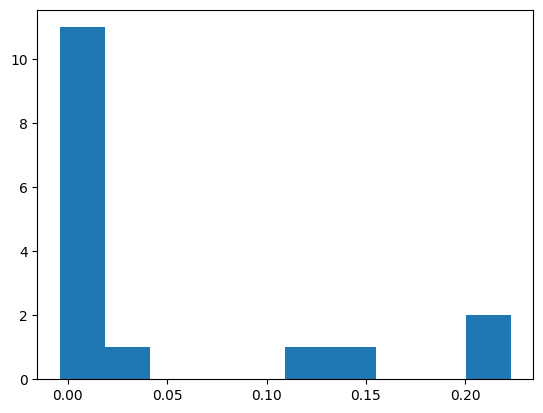

In [47]:
plt.hist(importance_df['importance_mean'].head(20),xlabel='Feature Importance', ylabel='Frequency', title='Top 20 Feature Importances')
